In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import StandardScaler

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
df = pd.read_csv("D:/Coding/Weather App/Weather_ML/data/temperature.csv")
df[:5]

,Temperature,Minimum Temperature,Maximum Temperature,Relative Humidity,Dew Point,Wind Speed,temp_lag1,temp_lag2,temp_mean_3,temp_mean_7,humidity_mean_7,sin_day,cos_day,sin_month,cos_month,target_temp
0,17.8,11.0,25.3,70.19,11.5,8.1,18.5,19.6,18.633333,19.628571,73.621429,0.120208,0.992749,0.5,0.866025,19.1
1,19.1,12.0,26.2,67.10,12.0,8.1,17.8,18.5,18.466667,19.514286,71.425714,0.137279,0.990532,0.5,0.866025,20.0
2,20.0,13.0,27.0,67.08,12.9,5.8,19.1,17.8,18.966667,19.428571,70.042857,0.154309,0.988023,0.5,0.866025,19.0
3,19.0,15.0,23.2,69.32,12.9,16.1,20.0,19.1,19.366667,19.128571,69.500000,0.171293,0.985220,0.5,0.866025,19.3
4,19.3,15.0,24.5,68.48,13.0,9.2,19.0,20.0,19.433333,19.042857,68.915714,0.188227,0.982126,0.5,0.866025,18.2


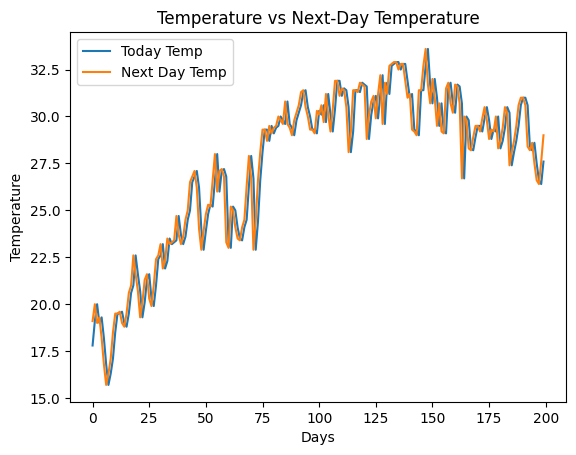

In [6]:
plt.figure()
plt.plot(df["Temperature"][:200], label="Today Temp")
plt.plot(df["target_temp"][:200], label="Next Day Temp")
plt.legend()
plt.title("Temperature vs Next-Day Temperature")
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.show()


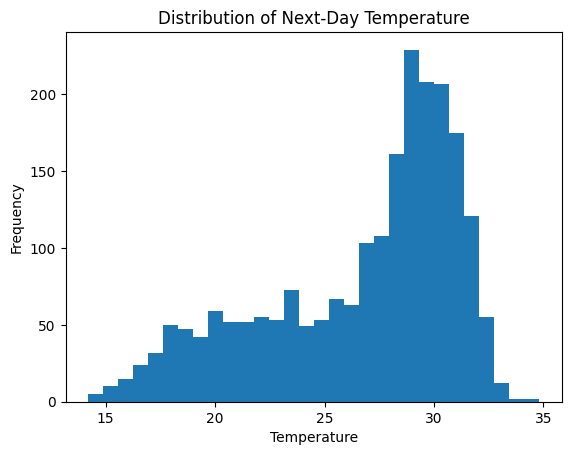

In [7]:
plt.figure()
plt.hist(df["target_temp"], bins=30)
plt.title("Distribution of Next-Day Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


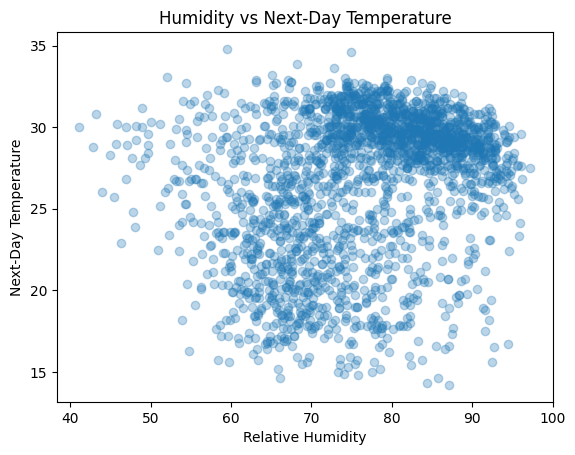

In [8]:
plt.figure()
plt.scatter(df["Relative Humidity"], df["target_temp"], alpha=0.3)
plt.xlabel("Relative Humidity")
plt.ylabel("Next-Day Temperature")
plt.title("Humidity vs Next-Day Temperature")
plt.show()


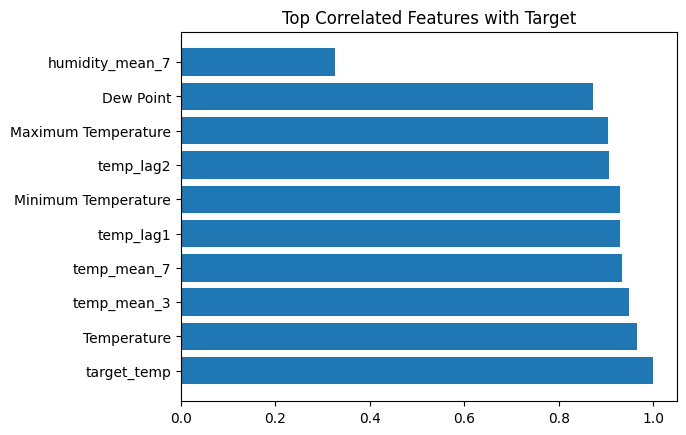

In [9]:
corr = df.corr()["target_temp"].sort_values(ascending=False)

plt.figure()
plt.barh(corr.index[:10], corr.values[:10])
plt.title("Top Correlated Features with Target")
plt.show()


In [10]:
X = df.drop(columns=["target_temp"])
y = df["target_temp"]

In [11]:
n = len(df)

In [12]:
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train = X.iloc[:train_end]
X_val   = X.iloc[train_end:val_end]
X_test  = X.iloc[val_end:]


y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

In [13]:
print(len(X), len(X_train), len(X_val), len(X_test))



2184 1528 328 328


In [14]:


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [15]:


class WeatherDataset(Dataset):
    def __init__(self, X, y, device):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [16]:
train_dataset = WeatherDataset(X_train_scaled, y_train, device)
val_dataset   = WeatherDataset(X_val_scaled, y_val, device)
test_dataset  = WeatherDataset(X_test_scaled, y_test, device)


In [17]:
x, y = train_dataset[0]
print(x.shape)   # torch.Size([15])
print(y.shape)   # torch.Size([])


torch.Size([15])
torch.Size([])


In [18]:
Batch_Size = 32

train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_Size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle=False)

In [19]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    print(y_batch.shape)
    break

torch.Size([32, 15])
torch.Size([32])


In [20]:
import torch.nn as nn 

class Temperature_model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
        
    def forward(self, x):
        return self.model(x)

In [24]:
input_dim = X_train.shape[1]

model = Temperature_model(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [26]:
epochs = 10000

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        preds = model(X_batch).squeeze()
        loss = criterion(preds, y_batch)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    # valodation
    
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            preds = model(X_batch).squeeze()
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    
    print(
        f"Epoch [{epoch+1}/{epochs}]"
        f"Train MSE: {train_loss:.4f} | "
        f"val MSE: {val_loss:.4f}"
    )

Epoch [1/10000]Train MSE: 556.1053 | val MSE: 581.1416
Epoch [2/10000]Train MSE: 554.0638 | val MSE: 575.5162
Epoch [3/10000]Train MSE: 551.8563 | val MSE: 572.5041
Epoch [4/10000]Train MSE: 549.0831 | val MSE: 570.1690
Epoch [5/10000]Train MSE: 547.3128 | val MSE: 571.6969
Epoch [6/10000]Train MSE: 545.4551 | val MSE: 564.1917
Epoch [7/10000]Train MSE: 542.9551 | val MSE: 558.1955
Epoch [8/10000]Train MSE: 538.7999 | val MSE: 560.8132
Epoch [9/10000]Train MSE: 537.3831 | val MSE: 561.4748
Epoch [10/10000]Train MSE: 534.4491 | val MSE: 551.6767
Epoch [11/10000]Train MSE: 532.5448 | val MSE: 551.1179
Epoch [12/10000]Train MSE: 529.8082 | val MSE: 545.7998
Epoch [13/10000]Train MSE: 527.3254 | val MSE: 546.2023
Epoch [14/10000]Train MSE: 526.9320 | val MSE: 547.4071
Epoch [15/10000]Train MSE: 522.7844 | val MSE: 543.5593
Epoch [16/10000]Train MSE: 519.5012 | val MSE: 535.8553
Epoch [17/10000]Train MSE: 517.1298 | val MSE: 538.4020
Epoch [18/10000]Train MSE: 514.9302 | val MSE: 535.1447
E

In [28]:
torch.save(model.state_dict(), "D:/Coding/Weather App/Weather_ML/models/Temperature_model.pth")

In [29]:
model = Temperature_model(input_dim)
model.load_state_dict(torch.load("D:/Coding/Weather App/Weather_ML/models/Temperature_model.pth", map_location=device))
model.to(device)
model.eval()


Temperature_model(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [31]:
import joblib
joblib.dump(scaler, "weather_scaler.pkl")

scaler = joblib.load("weather_scaler.pkl")



In [32]:
import numpy as np

day_of_year = 105
month = 4

sin_day = np.sin(2 * np.pi * day_of_year / 365)
cos_day = np.cos(2 * np.pi * day_of_year / 365)

sin_month = np.sin(2 * np.pi * month / 12)
cos_month = np.cos(2 * np.pi * month / 12)


In [36]:
import numpy as np

custom_input = np.array([[
    32.0,   # Temperature
    26.0,   # Min Temp
    38.0,   # Max Temp
    68.0,   # Relative Humidity
    24.0,   # Dew Point
    10.0,   # Wind Speed
    31.5,   # temp_lag1
    30.8,   # temp_lag2
    31.4,   # temp_mean_3
    30.9,   # temp_mean_7
    89.0,   # humidity_mean_7
    sin_day,
    cos_day,
    sin_month,
    cos_month
]])


In [37]:
custom_input_scaled = scaler.transform(custom_input)


d:\Coding\Weather App\Weather_ML\Weather\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [38]:
import torch

model.eval()

with torch.no_grad():
    x = torch.tensor(custom_input_scaled, dtype=torch.float32).to(device)
    prediction = model(x).item()

print(f"Predicted next-day temperature: {prediction:.2f} °C")


Predicted next-day temperature: 29.55 °C
